In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu

file_path = 'data//avito_new_data_for_dano.xlsx'
data = pd.read_excel(file_path)

In [47]:
# Выбор ключевых столбцов
columns = ['photo_count', 'has_video', 'description_length', 'page_views', 'contacts', 'favorites']
data = data[columns]

# Проверка на пропуски
print(data.isnull().sum())

# Удаление строк с пропусками
data = data.dropna()

# Создание метрики ликвидности
data['liquidity_score'] = data['page_views']

# Просмотр итогового набора данных
print(data.describe())

photo_count           0
has_video             0
description_length    0
page_views            0
contacts              0
favorites             0
dtype: int64
        photo_count  description_length    page_views      contacts  \
count  50000.000000        50000.000000  50000.000000  50000.000000   
mean       3.723880          284.722140    137.963400      2.472020   
std        2.439876          299.344023    393.870037      7.503475   
min        0.000000            1.000000      0.000000      0.000000   
25%        2.000000          103.000000     11.000000      0.000000   
50%        3.000000          187.000000     34.000000      0.000000   
75%        5.000000          355.000000    119.000000      2.000000   
max       10.000000         5548.000000  24336.000000    264.000000   

          favorites  liquidity_score  
count  50000.000000     50000.000000  
mean       7.051620       137.963400  
std       23.194765       393.870037  
min        0.000000         0.000000  
25%     

D:\Программы\Temp\Temp\ipykernel_20000\1623100110.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  photo_liquidity = data.groupby('photo_group')['liquidity_score'].mean()


photo_group
Мало           130.746069
Средне         130.760211
Много          140.207041
Очень много    171.424130
Name: liquidity_score, dtype: float64


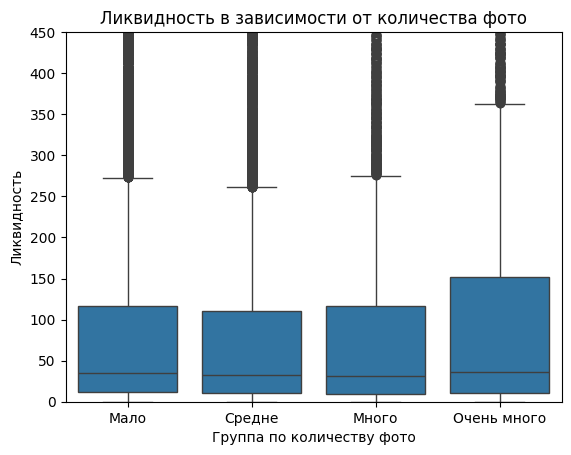

In [49]:
# Группировка по количеству фото
data['photo_group'] = pd.cut(data['photo_count'], bins=[0, 2, 4, 6, 10], labels=['Мало', 'Средне', 'Много', 'Очень много'])

# Средняя ликвидность по группам
photo_liquidity = data.groupby('photo_group')['liquidity_score'].mean()
print(photo_liquidity)

# Визуализация
sns.boxplot(x='photo_group', y='liquidity_score', data=data)
plt.title('Ликвидность в зависимости от количества фото')
plt.xlabel('Группа по количеству фото')
plt.ylabel('Ликвидность')
plt.ylim(0, 450)
plt.show()

has_video
False    137.314764
True     168.231649
Name: liquidity_score, dtype: float64
T-test: t_stat=2.5156456097072106, p_value=0.011884566088477537


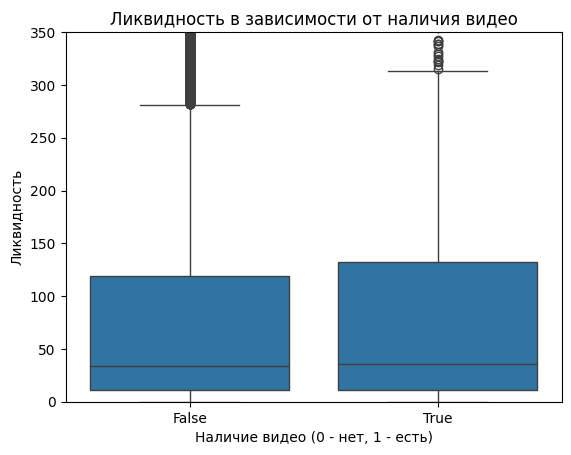

In [50]:
# Группировка по наличию видео
video_liquidity = data.groupby('has_video')['liquidity_score'].mean()
print(video_liquidity)

# Статистический тест
video_with = data[data['has_video'] == 1]['liquidity_score']
video_without = data[data['has_video'] == 0]['liquidity_score']
t_stat, p_value = ttest_ind(video_with, video_without)
print(f"T-test: t_stat={t_stat}, p_value={p_value}")

# Визуализация
sns.boxplot(x='has_video', y='liquidity_score', data=data)
plt.title('Ликвидность в зависимости от наличия видео')
plt.xlabel('Наличие видео (0 - нет, 1 - есть)')
plt.ylabel('Ликвидность')
plt.ylim(0, 350)
plt.show()

D:\Программы\Temp\Temp\ipykernel_20000\3596843974.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  text_liquidity = data.groupby('text_group')['liquidity_score'].mean()


text_group
Короткий         124.194995
Средний          141.587916
Длинный          146.195120
Очень длинный    128.105540
Name: liquidity_score, dtype: float64


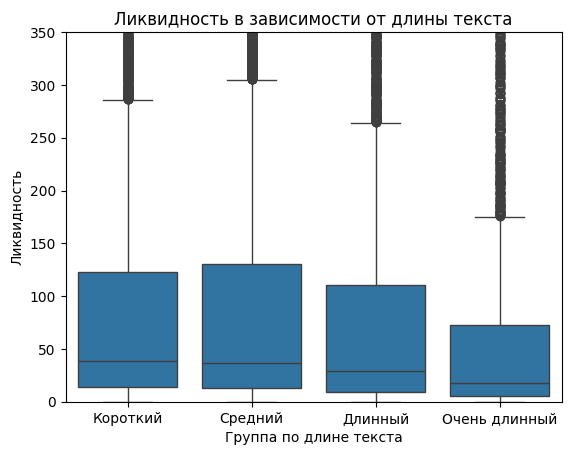

In [51]:
# Группировка по длине текста
data['text_group'] = pd.cut(data['description_length'], bins=[0, 100, 300, 600, 1200], labels=['Короткий', 'Средний', 'Длинный', 'Очень длинный'])

# Средняя ликвидность по группам
text_liquidity = data.groupby('text_group')['liquidity_score'].mean()
print(text_liquidity)

# Визуализация
sns.boxplot(x='text_group', y='liquidity_score', data=data)
plt.title('Ликвидность в зависимости от длины текста')
plt.xlabel('Группа по длине текста')
plt.ylabel('Ликвидность')
plt.ylim(0, 350)
plt.show()

In [52]:
import statsmodels.api as sm

# Подготовка данных для регрессии
X = data[['photo_count', 'has_video', 'description_length']]
X = sm.add_constant(X)  # Добавление константы
y = data['liquidity_score']

# Построение модели
model = sm.OLS(y, X.astype(int)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        liquidity_score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     20.99
Date:                Wed, 11 Dec 2024   Prob (F-statistic):           1.40e-13
Time:                        19:05:12   Log-Likelihood:            -3.6972e+05
No. Observations:               50000   AIC:                         7.394e+05
Df Residuals:                   49996   BIC:                         7.395e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                115.9489      3